In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("features.csv", low_memory=False)
print("Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()

Dataset loaded successfully!
Shape: (501483, 77)


,loan_amnt,int_rate,installment,grade,emp_length,home_ownership,annual_inc,issue_d,loan_status,dti,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term_ 36 months,term_ 60 months,application_type_Individual,application_type_Joint App,fico_score,last_fico_score
0,3600.0,13.99,123.03,3,10,2,55000.0,2015-12-01,1,5.91,...,178050.0,7746.0,2400.0,13734.0,1,0,1,0,677.0,562.0
1,24700.0,11.99,820.28,3,10,2,65000.0,2015-12-01,1,16.06,...,314017.0,39475.0,79300.0,24667.0,1,0,1,0,717.0,697.0
2,10400.0,22.45,289.91,6,3,2,104433.0,2015-12-01,1,25.37,...,439570.0,95768.0,20300.0,88097.0,0,1,1,0,697.0,702.0
3,20000.0,9.17,637.58,2,10,2,180000.0,2015-12-01,1,14.67,...,388852.0,116762.0,31500.0,46452.0,1,0,1,0,682.0,652.0
4,20000.0,8.49,631.26,2,10,2,85000.0,2015-12-01,1,17.61,...,193390.0,27937.0,14500.0,36144.0,1,0,1,0,707.0,672.0


In [3]:
X = df.drop(columns=['loan_amnt'])
y = df['loan_amnt']


In [4]:
# Handle categorical columns safely (limit to top 10 categories)
for col in X.select_dtypes(include='object').columns:
    top_10 = X[col].value_counts().index[:10]
    X[col] = X[col].where(X[col].isin(top_10), other='Other')

# Convert categorical columns to dummy variables
X = pd.get_dummies(X, drop_first=True)
print("After encoding:", X.shape)

After encoding: (501483, 117)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [6]:
clf = DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)

print("Baseline Model Results:")
print("R² (Train):", clf.score(X_train, y_train))
print("R² (Test) :", clf.score(X_test, y_test))

Baseline Model Results:
R² (Train): 1.0
R² (Test) : 0.9999051716209411


In [7]:
param_grid = {
    'criterion': ['squared_error', 'friedman_mse'],  # smaller list
    'max_depth': [6, 8, 10],                         # fewer depths
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'splitter': ['best']
}

search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=5,        # only test 5 combos
    cv=2,            # only 2-fold cross-validation
    scoring='r2',
    n_jobs=1,
    pre_dispatch=1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
DT_model = search.best_estimator_

print("\n--- TUNED MODEL ---")
print("Best Parameters:", search.best_params_)
print("R² (Train):", DT_model.score(X_train, y_train))
print("R² (Test) :", DT_model.score(X_test, y_test))

Fitting 2 folds for each of 5 candidates, totalling 10 fits

--- TUNED MODEL ---
Best Parameters: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 10, 'criterion': 'squared_error'}
R² (Train): 0.9990998943260174
R² (Test) : 0.9990948149171023


In [8]:
y_pred = DT_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Model Evaluation Metrics:
MAE : 135.14395731351493
RMSE: 282.66364239707923
R²  : 0.9990948149171023


In [9]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(DT_model, X_train, y_train, cv=kfold, scoring='r2')

print("\nK-Fold Cross Validation Results:")
print("CV Scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))
print("Std Dev:", np.std(cv_scores))


K-Fold Cross Validation Results:
CV Scores: [0.99892522 0.99909754 0.99908029 0.99910796 0.99913924]
Mean R²: 0.9990700486669712
Std Dev: 7.491617593767597e-05


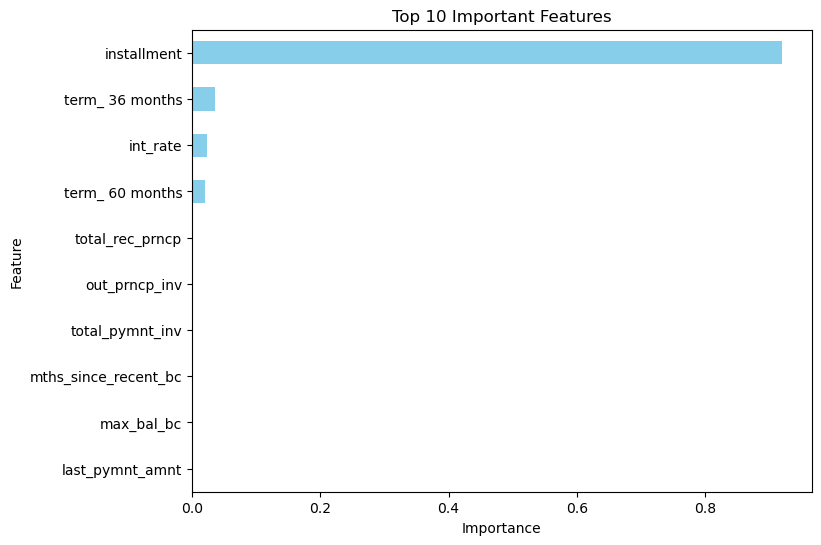

In [10]:
feature_importance = pd.Series(DT_model.feature_importances_, index=X.columns)
top_features = feature_importance.nlargest(10)

plt.figure(figsize=(8,6))
top_features.plot(kind='barh', color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()